In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Monte Carlo Integration
Estimate multi-dimensional integral (over unit hypercube) by randomly sampling $N$ abscissas: 
$$ I = \int{d^dx \; f(x)} \approx  E = \frac{1}{N} \sum_{n=1}^{N}{f(x_n)} , $$
with equality for $N \rightarrow \infty $ (if the random process used to sample $x_n$ has a constant natural density). Define variance of a function $f$ as
$$ \sigma^2(f) = \int { d^dx \; (f(x)-I)^2 } .$$
Using this, the variance of the Monte Carlo estimate is
$$ 
\int { dx_1...dx_N \left( \frac{1}{N} \sum_{n=1}^N f(x_n)- I \right)^2 }
= \int { dx_1...dx_N \frac{1}{N^2} \sum_{n=1}^N \sum_{m=1}^N (f(x_n)- I)(f(x_m)- I) } 
= \int {dx_1...dx_N \frac{1}{N^2} \sum_n{(f(x_n)-I)^2}}
= \frac{\sigma(f)^2}{N},
$$
since for $n \neq m$ the integrals separate and clearly $\int{dx\;(f(x)-I)} = 0$. 

The variance can be estimated using the unbiased sample variance
$$ S^2 = \frac{1}{N-1} \sum_{n=1}^N{(f(x_n)-E)^2} = \frac{1}{N-1}\sum_n{f(x_n)^2 } - \frac{N}{N-1}E^2$$

In [3]:
class monte_carlo_unit(f, N, dim=1):
    """ Compute Monte Carlo estimate of N-dimensional integral of f over the unit hypercube.
    
    Returns:
        tuple (integral_estimate, error_estimate),
        where the error_estimate is based on the unbiased sample variance of the function,
        computed on the same sample as the integral.
    """
    int_est = 0  # estimated integral of f
    var_est = 0  # estimated variance of f
    for i in range(N):
        x = np.random.rand(dim)
        value = float(f(x))       # f must return a 1D np.ndarray
        int_est += value/N  # int_est is just the average of f over N values (multiplied by volume = 1)
        var_est += value**2/(N-1)
    var_est -= N/(N-1) * int_est**2
    return int_est, np.sqrt(var_est/N)    

({'monte_carlo_unit': -0.049207039961339585},
 {'monte_carlo_unit': 1.9740665225620444})

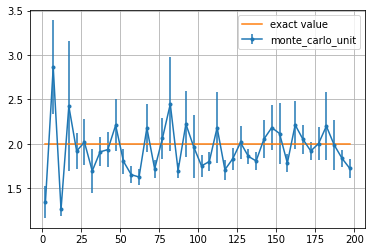

In [4]:
def compare_integration(f, true_value, methods=[monte_carlo_unit],  Nmin=2, Nmax=200, Nstep=5, dim=1):
    """ Plot the exact value vs the estimates and errors of each method for various sample sizes. """
    Ns = list(range(Nmin, Nmax+1, Nstep))  # sample sizes
    samples_count = len(Ns)                # number of different sample sizes
    
    estimate = np.empty(samples_count)  # integral for each sample size
    error = np.empty(samples_count)     # error estimate for each sample size
    
    # keep track of average variances * sqrt(N)
    av_var = dict()
    av_diff = dict()
    
    for method in methods:
        for i in range(samples_count):
            estimate[i], error[i] = method(f, Ns[i], dim=dim)
        av_var[method.__name__] = np.average(np.sqrt(Ns)*error)
        av_diff[method.__name__] = np.average(estimate - true_value)
        # plot estimated integral with one-sigma error interval
        plt.errorbar(Ns, estimate, yerr=error, fmt=".-", label=method.__name__)
    # plot true value
    plt.plot([Ns[0], Ns[-1]], [true_value, true_value], "-", label="exact value")
    # configure plot
    plt.grid()
    plt.legend(loc="best")
    
    return av_diff, av_var

# f(x) = 1/sqrt(x) is integrable and MC converges to true value, but error estimate relied on square-integrability.
# the variance of f does not converge, which implies the estimate of this cannot yield a good error estimate
compare_integration(lambda x: 1/np.sqrt(x), 2, Nmax=200, Nstep=5)

## Variance Reducing Techniques
The error in the MC estimate scales like $1/\sqrt{N}$, which constitutes a slow convergence. Improving this value is desirable.
### stratified sampling
Split $M=[0,1]^d$ into $k$ regions $M_j$, in each region perform MC with $N_j$ points. We obtain the estimate
$$ E = \sum_{j=1}^k {\frac{\text{vol}(M_j)}{N_j}} \sum_{n=1}^{N_j} {f(x_{jn})}, $$
and the variance of the MC estimate becomes
$$ 
\sum_{j=1}^k {\frac{\text{vol}(M_j)^2}{N_j} \left.\sigma^2(f)\right|_{M_j} }, \; \text{with} \;  
\left.\sigma^2(f)\right|_{M_j} = \frac{1}{\text{vol}(M_j)}\int_{M_j} {dx \left( f(x) - \frac{1}{\text{vol}(M_j)}\int_{M_j}{dx f(x)}  \right)^2}.
$$
Whether this method reduces or increases the variance depends on the choice of subspaces and respective point counts. It is obvious from the expression that to reduce the error/variance, regions with larger variance should have assigned larger $N_j$. Generally, for minimal variance the number of points must be chosen proportional to $\left.\sigma(f)\right|_{M_j}$.

In [5]:
# For the strafield monte carlo varient we first need a way to encode the volumes, 
# iterate over them and sample each one appropriately.
# The simplest division is simple cubic
class CubeVolumes(object):
    def __init__(self, divisions:int, Ns={}, otherNs=1, dim=1):
        """ Initialize a division of a <dim>-dimensional hypercube into <divisions> cubes along each dimension.
        
        divisions: number of subregions along one axis. For dim=3, there will be divisions^3 subregions.
        Ns: dictionary for setting the number of samples for specific subregions (cubes).
            Example: Ns={(1,0,0): 4} to assign 4 samples to the cube 1 away from the origion along the first dimension.
        otherNs: number of samples to be assigned to all remaining cubes.
        dim: dimensionality of the cube.
        """
        self.Ns = Ns
        self.divisions = divisions
        self.dim = dim
        # volume of all regions is constant
        self.vol = 1/divisions**dim
        self.otherNs = otherNs
        self.totalN = sum(Ns.values()) + (divisions**dim - len(Ns)) * otherNs
    
    def iterate(self, multiple=1):
        """ multiply N in each division by multiple. Total number of samples is self.totalN()*multiple. 
        
        yields tuple (N, sample, vol), 
        where N is the number of samples in the region, sample is a function that samples the region uniformly.
        """
        for index in np.ndindex(*([self.divisions]*self.dim)):
            def sample_region():
                return np.array(index) / self.divisions + np.random.rand(self.dim) / self.divisions
            yield multiple * (self.Ns[index] if index in self.Ns else self.otherNs), sample_region, self.vol

# iterate and sample a 1D volume, divided into 5 regions, with doulbe weight on the fourth region (index (3,))
# volumes = CubeVolumes(5, Ns={(3,): 2}, otherNs=1)
volumes = CubeVolumes(2, otherNs=2, Ns={(0,):2})
for N, sample, vol in volumes.iterate(2):
    print(N, vol, [(lambda x: 1+(x<.5)*np.sin(np.pi*x))(sample()) for i in range(N)])

4 0.5 [array([1.6846631]), array([1.88536796]), array([1.3961455]), array([1.81029207])]
4 0.5 [array([1.]), array([1.]), array([1.]), array([1.])]


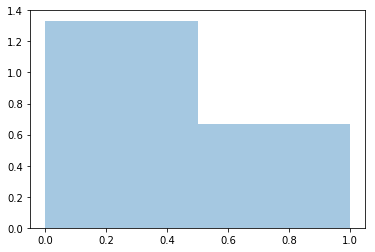

In [220]:
# visualization of 1d volumes
def plot_1d_volume(volumes, label="sampling weights"):
    assert volumes.dim == 1, "Can only plot volumes in 1 dimension."
    x = [volumes.vol*i for i in range(volumes.divisions)]
    height = [N/volumes.totalN/volumes.vol for N,_,_ in volumes.iterate()] # bar height corresponds to pdf
    rects1 = plt.bar(x, height, volumes.vol, align='edge', alpha=.4, label=label)
plot_1d_volume(CubeVolumes(2, otherNs=2, Ns={(1,): 1}))

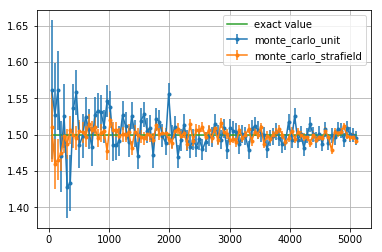

monte_carlo_unit	 average deviation: 0.0023416984597428026, error*sqrt(N): 0.7049556023724008
monte_carlo_strafield	 average deviation: -0.0013071420143895972, error*sqrt(N): 0.35704543734137995


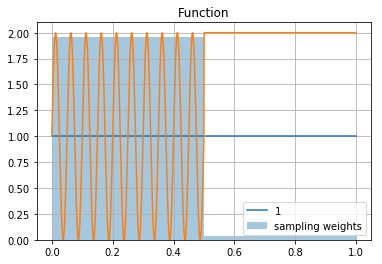

In [91]:
def monte_carlo_strafield(f, N, dim=1, volumes=CubeVolumes(1)):
    """ Compute Monte Carlo estimate of N-dimensional integral of f over the unit hypercube using strafield sampling.
    
    Note: N must be an integer multiple of volumes.totalN !

    Returns:
        tuple (integral_estimate, error_estimate)
    """
    multiple = N // volumes.totalN 
    assert multiple > 0, "the strafield method requires the sample size N to be a multiple of volumes.totalN."
    int_est = 0
    var_est = 0 # estimated variance of 
    for Nj, sample, vol in volumes.iterate(multiple):
        f_average = 0   # average of f over N samples
        f2_average = 0  # average of f^2 over N samples
        for i in range(Nj):
            x = sample()
            value = float(f(x)) # f must return a 1D value
            f_average += value/Nj
            f2_average += value**2/Nj
        var_est += vol**2/Nj * (f2_average - f_average**2)
        int_est += vol * f_average
    return int_est, np.sqrt(var_est)

def fix_args(method, **defaultkwargs):
    name = defaultkwargs.pop("__name__") if "__name__" in defaultkwargs else method.__name__
    
    def monte_carlo(*args, **kwargs):
        for key in defaultkwargs:
            if key not in kwargs:
                kwargs[key] = defaultkwargs[key]
        return method(*args, **kwargs)
    monte_carlo.__name__ = name
    
    return monte_carlo

volumes = CubeVolumes(2, otherNs=1, Ns={(0,):50})
f = lambda x: (x<.5)*(1+np.sin(4*10*np.pi*x)) + (x>.5)*2
diff, err = compare_integration(f, 1.5, Nmin=volumes.totalN, Nmax=volumes.totalN*100, Nstep=volumes.totalN, 
                    methods=[monte_carlo_unit, fix_args(monte_carlo_strafield, volumes=volumes)])
plt.show()
for key in diff:
    print("%s\t average deviation: %s, error*sqrt(N): %s" % (key, diff[key], err[key]))

plt.title("Function")
plot_1d_volume(volumes)
x = np.linspace(0,1,1000)
plt.plot(x, [1 for i in x], label="1")
plt.plot(x,f(x))
plt.grid()
plt.legend()
plt.show()

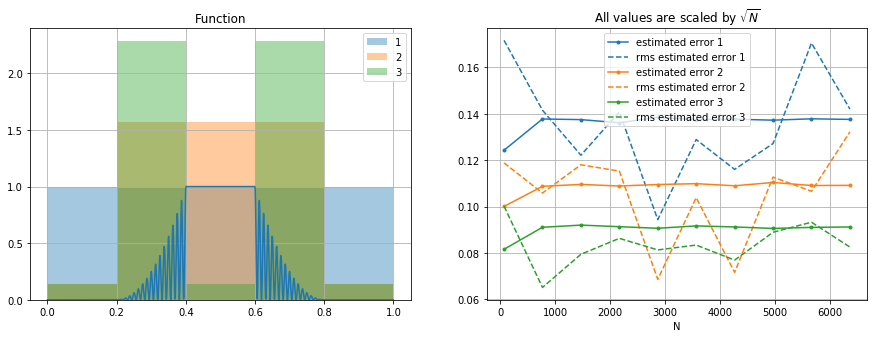

In [92]:
a = 16
b = 1/.2**2
def osc(x):
    return x**2*np.cos(a*np.pi*x/.2)**2*b
def bound(a, x, b):
    return (x>a)*(x<=b)
def test_function(x):
    return bound(.2, x, .4)*osc(x-.2) + bound(.4, x, .6) + bound(.6, x, .8)*osc(.8-x)
true_value = 2*.0333531 + .2

# plot function and volume choices for stratified sampling
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Function")
x = np.linspace(0,1,1000)
plt.plot(x,test_function(x))
plt.grid()

vol1 = CubeVolumes(5, otherNs=14)
vol2 = CubeVolumes(5, otherNs=2, Ns={(1,):22, (3,):22, (2,):22})
vol3 = CubeVolumes(5, otherNs=2, Ns={(1,):32, (3,):32})
plot_1d_volume(vol1, "1")
plot_1d_volume(vol2, "2")
plot_1d_volume(vol3, "3")
plt.legend()

plt.subplot(122)

def compare_errors(f, true_value, iterations=1, Nmin=2, Nmax=100, Nstep=1, methods=[], dim=1):
    Ns = list(range(Nmin, Nmax+1, Nstep))  # sample sizes
    samples_count = len(Ns)                # number of different sample sizes
    
    errors = np.zeros(samples_count)
    ms = np.zeros(samples_count)
    for m in range(len(methods)):
        for i in range(samples_count):
            errors[i] = 0
            ms[i] = 0
            for j in range(iterations):
                val, err = methods[m](f, Ns[i], dim=dim)
                errors[i] += err/iterations
                ms[i] += (val-true_value)**2/iterations
                
        # plot average error
        plt.title("All values are scaled by $\\sqrt{N}$")
        plt.xlabel("N")
        plt.plot(Ns, errors*np.sqrt(Ns), ".-", label=methods[m].__name__, color="C%d"%m)
        plt.plot(Ns, np.sqrt(ms)*np.sqrt(Ns), "--", label="rms %s"%methods[m].__name__, color="C%d"%m)
        # configure plot
        plt.grid()
        plt.legend(loc="best")

compare_errors(test_function, true_value, iterations=20, Nmin=vol1.totalN, Nmax=vol1.totalN*100, Nstep=vol1.totalN*10, 
                    methods=[fix_args(monte_carlo_strafield, __name__="estimated error 1", volumes=vol1),
                             fix_args(monte_carlo_strafield, __name__="estimated error 2", volumes=vol2),
                             fix_args(monte_carlo_strafield, __name__="estimated error 3", volumes=vol3)])
plt.show()

**Observation**: It is most important to increase sampling in regions where f varies quickly.

(Note: stratified sampling is substantially different from importance sampling, which is why for stratified sampling regions of large variance of f should have bigger weights, whereas for importance sampling the pdf should be as close to f as possible.
In stratified sampling each region is considered individually and therefore when f is large but constant small samples will be acceptable. If $p(x)$ in importance sampling is small in these regions, these large values of f would be underrepresented and (as they yield large values of $f(x)/p(x)$) increase the variance of the MC estimate.)

### importance sampling
Consider a change of variables
$$ \int {dx \; f(x)} = \int {\frac{f(x)}{p(x)} dx} = \int {\frac{f(x)}{p(x)} dP(x)} $$
with $$ p(x) = \frac{\partial^d}{\partial x_1 ... \partial x_d} P(x) .$$

Interpret $p(x)$ as a probability density with $p(x) \geq 0$ and normalized: $\int{dx\;p(x)} = 1$. If the $x_n$ are sampled from the corresponding distribution $P(x)$, we have
$$ E = \frac{1}{N} \sum_{n=1}^{N}{\frac{f(x_n)}{p(x_n)}}.$$
The variance of the MC estimate is (analogously to the first calculation)
$$ 
\int { dx_1...dx_N \; p(x_1)...p(x_N)\left( \frac{1}{N} \sum_{n=1}^N f(x_n)- I \right)^2 } 
= \frac{1}{N} \int {dx \; p(x) \left( \frac{f(x)}{p(x)} - I \right)^2 } = \frac{\sigma^2(f/p)}{N} \;,
$$
which may in turn be estimated by the sample variance, using E instead of I:
$$ 
\sigma^2\left(\frac{f}{p}\right) \approx S^2\left(\frac{f}{p}\right) 
= \frac{1}{N} \sum_{n=1}^N {\left(\frac{f(x_n)}{p(x_n)}\right)^2} - E^2 .
$$

Using $p$ which are (close to) zero where $f$ is not zero is dangerous as the variance diverges while the sample variance does not (appropriate regions are less likely to be sampled for small $p$).

({'monte_carlo_importance': -0.0004652403229378133,
  'monte_carlo_unit': 0.0005979349277647517},
 {'monte_carlo_importance': 0.3537850278230513,
  'monte_carlo_unit': 0.3527365217063131})

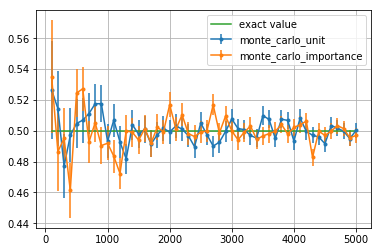

In [197]:
def monte_carlo_importance(f, N, dim=1, sampling_fn=np.random.rand, pdf=lambda x:1):
    """ sampling_fn returns random number according to the desired distribution. """
    int_est = 0
    var_est = 0  # variance of (f/weight_fn)
    for i in range(N):
        x = sampling_fn()
        int_est += f(x)/pdf(x)/N
        var_est += np.power(f(x)/pdf(x),2)/N
    var_est -= int_est**2
    return int_est, np.sqrt(var_est/N)

f = lambda x: np.sin(x*2*np.pi)**2
# with the default values (uniform distribution) monte carlo importance and plain monte carlo are exactly equivalent 
compare_integration(f, 1/2, Nmin=100, Nmax=5000, Nstep=100, 
                    methods=[monte_carlo_unit, monte_carlo_importance])

## Generating Samples from a Given Distribution
### Acceptance-Rejection method
We want to sample according to a pdf $p(x)$. We know another (similar) pdf $h(x)$ s.t. $p(x) \leq Ch(x)$ for some $C \geq 0$.
Then use the following algorithm:
1. sample $x$ according to $h$
2. generate random number $u \in [0,1]$ and accept $x$ if $p(x) \geq uCh(x)$, else reject and start over

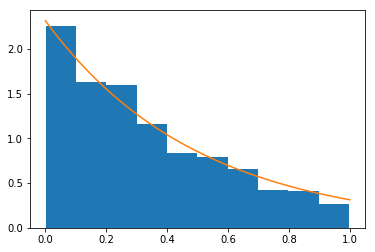

In [147]:
class AcceptionRejection(object):
    # for use in monte carlo it will be useful to have a parameter-less sample function, therefore use a callable object
    def __init__(self, p, C, h=lambda x: 1, h_sampling=np.random.rand):
        self.p = p
        self.C = C
        self.h = h
        self.sample = h_sampling
    def __call__(self):
        while True:
            x = self.sample()
            if np.random.rand() * self.C * self.h(x) <= self.p(x):
                return x

a = 2
p = lambda x: a/(1-np.exp(-a)) * np.exp(-a*x)
acception_rejection = AcceptionRejection(p, 5)
plt.hist([acception_rejection() for i in range(1000)], bins=10, normed=True)
plt.plot(np.linspace(0,1,100), p(np.linspace(0,1,100)))

### Metropolis algorithm
The metropolis algorithm is a simple Markov chain that, in it's limit, generates the desired distribution.
It starts from a state $\phi$ and transitions to a new state $\phi'$.

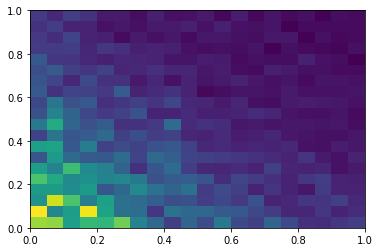

In [191]:
class Metropolis(object):
    def __init__(self, p, next_candidate=np.random.rand):
        self.p = p
        self.next_candidate = next_candidate
        self.state = next_candidate()
        
    def __call__(self):
        while True:
            candidate = self.next_candidate()
            r = p(candidate)/p(self.state)
            if r > 1 or np.random.rand() < r:
                self.state = candidate
            return self.state

a = 2
p = lambda x: a**2/(1-np.exp(-a))**2 * np.exp(-a*x[0]-a*x[1])
metropolis = Metropolis(p, next_candidate=lambda: np.random.rand(2))
rand = np.array([metropolis() for i in range(10000)]).transpose()
_= plt.hist2d(rand[0], rand[1], bins=20, normed=True)

({'monte_carlo_importance': 0.0009023482712099462,
  'monte_carlo_unit': 0.0030806983557766176},
 {'monte_carlo_importance': 0.031017349319768732,
  'monte_carlo_unit': 0.35375100402893317})

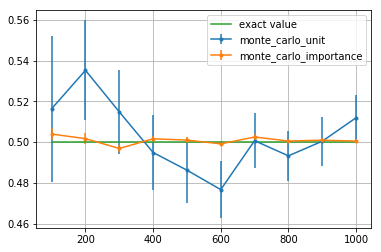

In [206]:
# Now apply distributions to importance sampling


f = lambda x: np.sin(x*2*np.pi)**2

p_ideal = lambda x: f(x+.005) / (1/2) # almost ideal
sampling = AcceptionRejection(p_ideal, 2) # max value of f is 1

compare_integration(f, 1/2, Nmin=100, Nmax=1000, Nstep=100, 
                    methods=[monte_carlo_unit, fix_args(monte_carlo_importance, sampling_fn=sampling, pdf=p_ideal)])

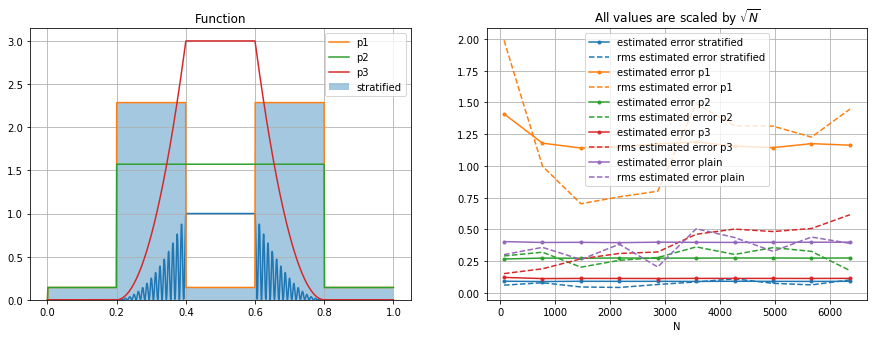

In [228]:
# use test_function and true_value from earlier
a = 16
b = 1/.2**2
def osc(x):
    return x**2*np.cos(a*np.pi*x/.2)**2*b
def bound(a, x, b):
    return (x>a)*(x<=b)
def test_function(x):
    return bound(.2, x, .4)*osc(x-.2) + bound(.4, x, .6) + bound(.6, x, .8)*osc(.8-x)
true_value = 2*.0333531 + .2

# compare importance sampling to the stratified boxing from before
vol = CubeVolumes(5, otherNs=2, Ns={(1,):32, (3,):32})
p1 = lambda x: (bound(0,x,.2)*2 + bound(.2,x,.4)*32 + bound(.4,x,.6)*2 + bound(.6,x,.8)*32 + bound(.8,x,1)*2)/vol.totalN/.2
p2 = lambda x: (bound(0,x,.2)*2 + bound(.2,x,.4)*22 + bound(.4,x,.6)*22 + bound(.6,x,.8)*22 + bound(.8,x,1)*2)/vol.totalN/.2
p3 = lambda x: (bound(.2,x,.4)*((x-.2)/.2)**2 + bound(.6,x,.8)*((.8-x)/.2)**2 + bound(.4,x,.6))/(.2 + .1333333)
sampling1 = AcceptionRejection(p1, 3)
sampling2 = AcceptionRejection(p2, 2)
sampling3 = AcceptionRejection(p3, 1/.4)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Function")
x = np.linspace(0,1,1000)
plt.plot(x,test_function(x))
plt.grid()

plt.plot(x,p1(x), label="p1")
plt.plot(x,p2(x), label="p2")
plt.plot(x,p3(x), label="p3")
plot_1d_volume(vol, "stratified")
plt.legend()

plt.subplot(122)
compare_errors(test_function, true_value, iterations=10, Nmin=vol1.totalN, Nmax=vol1.totalN*100, Nstep=vol1.totalN*10, 
                    methods=[fix_args(monte_carlo_strafield, __name__="stratified", volumes=vol),
                             fix_args(monte_carlo_importance, __name__="p1", sampling_fn=sampling1, pdf=p1),
                             fix_args(monte_carlo_importance, __name__="p2", sampling_fn=sampling2, pdf=p2),
                             fix_args(monte_carlo_importance, __name__="p3", sampling_fn=sampling3, pdf=p3),
                             fix_args(monte_carlo_unit, __name__="plain")])
plt.show()